In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## load data

In [1]:
!unzip -q train.zip
!ls

__MACOSX  sample_data  train  train.zip


In [2]:
!ls train

classic  modern


# Classifing paintings

### Filter out corrupted images

When working with lots of real-world image data, corrupted images are a common
occurence. Let's filter out badly-encoded images that do not feature the string "JFIF"
 in their header.


In [5]:
import os

num_skipped = 0
for folder_name in ("classic", "modern"):
    folder_path = os.path.join("train", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 2 images


In [6]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "train",
    # validation_split=0.2,
    # subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 1868 files belonging to 2 classes.


## Visualize the data

Here are the first 9 images in the training dataset. As you can see, label 1 is "dog"
 and label 0 is "cat".


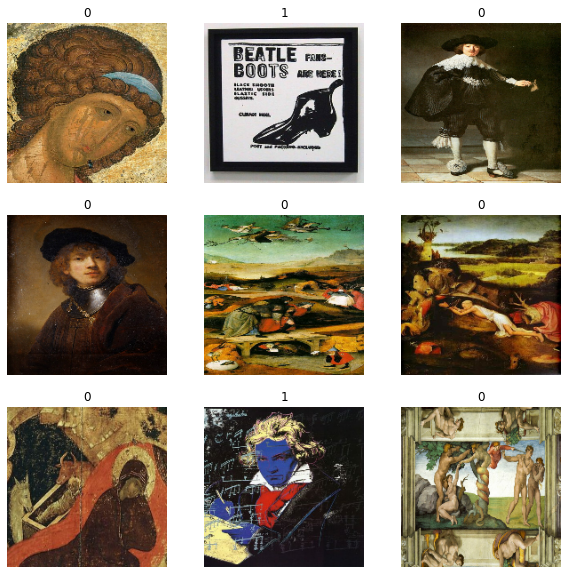

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

## Using image data augmentation

When you don't have a large image dataset, it's a good practice to artificially
introduce sample diversity by applying random yet realistic transformations to the
training images, such as random horizontal flipping or small random rotations. This
helps expose the model to different aspects of the training data while slowing down
 overfitting.


In [10]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

Let's visualize what the augmented samples look like, by applying `data_augmentation`
 repeatedly to the first image in the dataset:


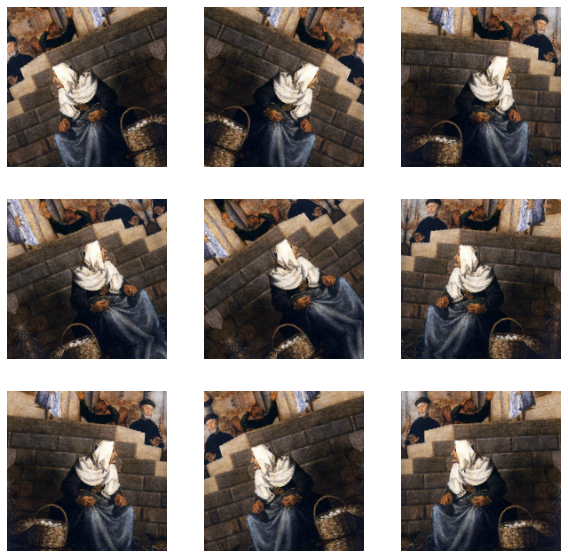

In [11]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[3].numpy().astype("uint8"))
        plt.axis("off")


## Build a model

We'll build a small version of the Xception network. We haven't particularly tried to
optimize the architecture; if you want to do a systematic search for the best model
 configuration, consider using
[KerasTuner](https://github.com/keras-team/keras-tuner).

Note that:

- We start the model with the `data_augmentation` preprocessor, followed by a
 `Rescaling` layer.
- We include a `Dropout` layer before the final classification layer.


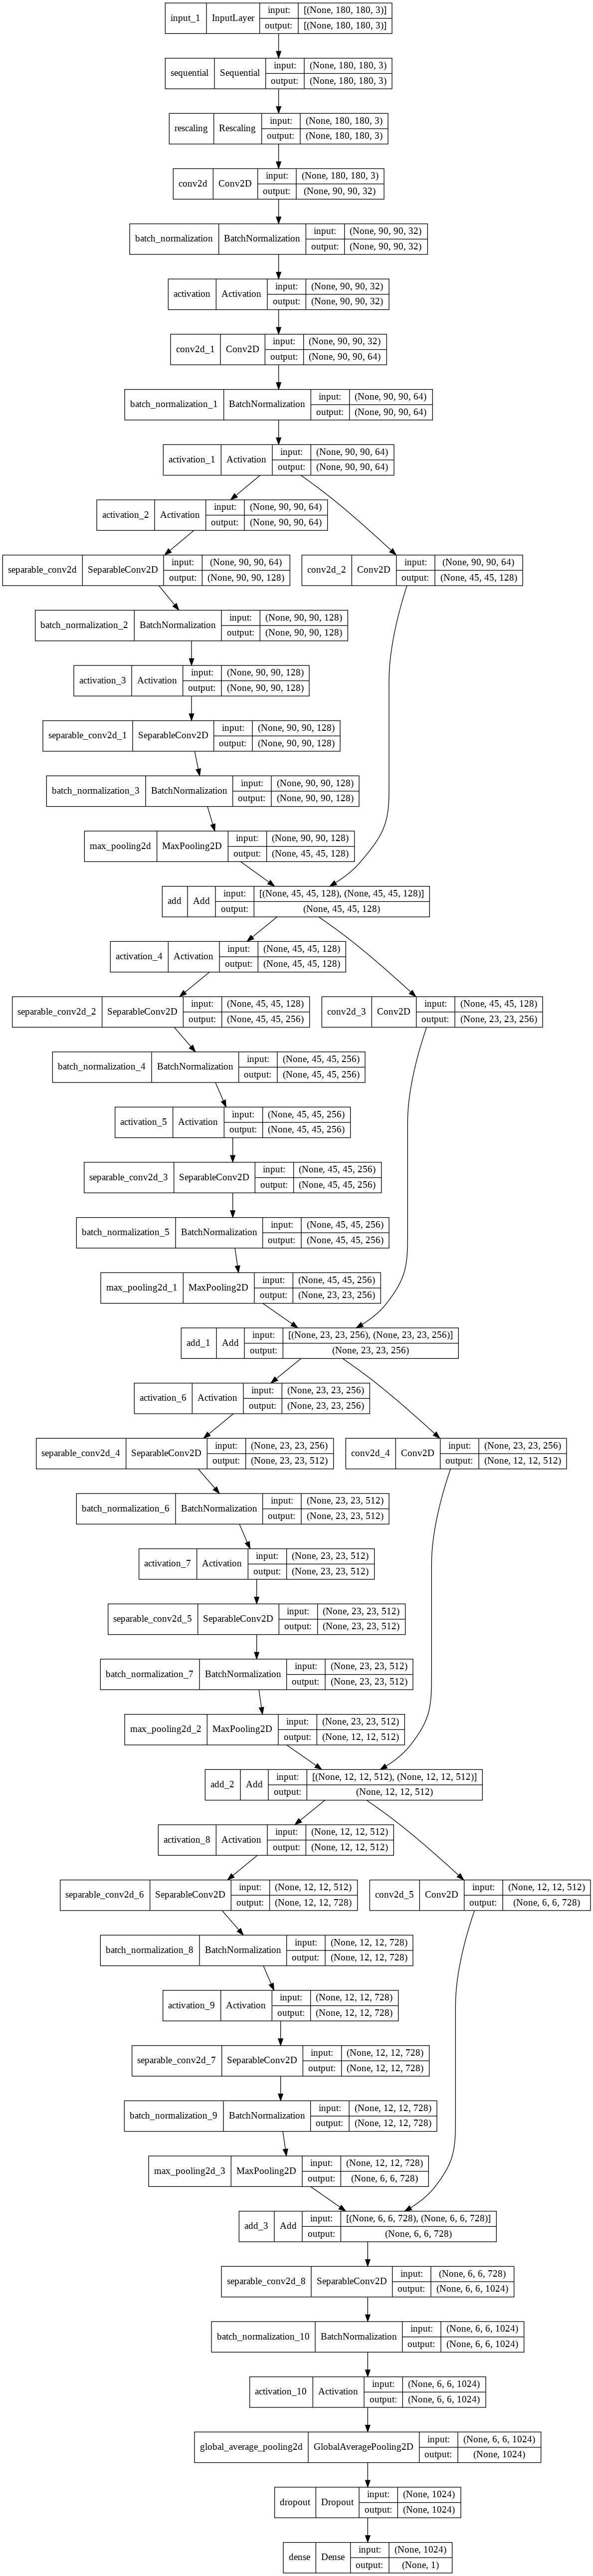

In [12]:

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)


## Train the model


In [44]:
epochs = 100

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks
    # , validation_data=val_ds
)


Epoch 1/100
59/59 [==============================] - 13s 181ms/step - loss: 0.2339 - accuracy: 0.9004


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 2/100
59/59 [==============================] - 11s 181ms/step - loss: 0.2324 - accuracy: 0.9106
Epoch 3/100
59/59 [==============================] - 11s 182ms/step - loss: 0.2120 - accuracy: 0.9133
Epoch 4/100
59/59 [==============================] - 11s 182ms/step - loss: 0.2123 - accuracy: 0.9202
Epoch 5/100
59/59 [==============================] - 11s 181ms/step - loss: 0.1992 - accuracy: 0.9143
Epoch 6/100
59/59 [==============================] - 11s 182ms/step - loss: 0.1926 - accuracy: 0.9202
Epoch 7/100
59/59 [==============================] - 11s 183ms/step - loss: 0.1885 - accuracy: 0.9234
Epoch 8/100
59/59 [==============================] - 11s 182ms/step - loss: 0.2092 - accuracy: 0.9208
Epoch 9/100
59/59 [==============================] - 11s 182ms/step - loss: 0.1789 - accuracy: 0.9218
Epoch 10/100
59/59 [==============================] - 11s 182ms/step - loss: 0.1892 - accuracy: 0.9277
Epoch 11/100
59/59 [==============================] - 11s 182ms/step - loss: 0.18

We get to ~xx% validation accuracy after training for 50 epochs on the full dataset.


## Run inference on new data

Note that data augmentation and dropout are inactive at inference time.


This image is 0.27 percent classic and 99.73 percent modern.


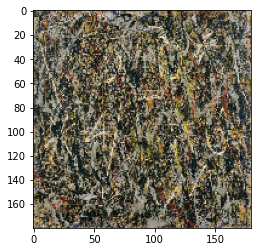

In [45]:
img = keras.preprocessing.image.load_img(
    "/content/val/modern/Jackson_Pollock_1.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
plt.imshow(img)
print(
    "This image is %.2f percent classic and %.2f percent modern."
    % (100 * (1 - score), 100 * score)
)


In [46]:
os.path.isdir('val/modern')

True

Marc_Chagall_234.jpg is 0.01 percent classic and 99.99 percent modern.
Gustav_Klimt_91.jpg is 4.06 percent classic and 95.94 percent modern.
Edgar_Degas_505.jpg is 100.00 percent classic and 0.00 percent modern.
Francisco_Goya_12.jpg is 100.00 percent classic and 0.00 percent modern.
Camille_Pissarro_30.jpg is 99.98 percent classic and 0.02 percent modern.
Camille_Pissarro_37.jpg is 100.00 percent classic and 0.00 percent modern.
Gustav_Klimt_100.jpg is 99.99 percent classic and 0.01 percent modern.
Amedeo_Modigliani_10.jpg is 0.32 percent classic and 99.68 percent modern.
Mikhail_Vrubel_95.jpg is 92.30 percent classic and 7.70 percent modern.
Amedeo_Modigliani_15.jpg is 99.66 percent classic and 0.34 percent modern.
Edgar_Degas_15.jpg is 100.00 percent classic and 0.00 percent modern.
Alfred_Sisley_254.jpg is 100.00 percent classic and 0.00 percent modern.
El_Greco_77.jpg is 87.57 percent classic and 12.43 percent modern.
Michelangelo_8.jpg is 99.99 percent classic and 0.01 percent mo

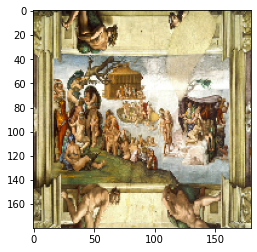

In [51]:
local_download_path='test'
for filename in os.listdir(local_download_path):
    if filename.endswith("jpg"): 
        # Your code comes here such as 
        img = keras.preprocessing.image.load_img(local_download_path+'/'+filename, target_size=image_size)
        img_array = keras.preprocessing.image.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)  # Create batch axis
        
        predictions = model.predict(img_array)
        score = predictions[0]
        art_type[filename]=[100 * (1 - score), 100 * score]

        plt.imshow(img)
        print(
            filename+" is %.2f percent classic and %.2f percent modern."
            % (100 * (1 - score), 100 * score))


## Classify all art works

In [8]:
model = keras.models.load_model('/content/save_at_100.h5')

In [19]:
!unzip -q '/content/drive/MyDrive/Colab Notebooks/Datasets/artworks.zip'

In [22]:
art_type={}
local_download_path='/content/artworks'
for filename in os.listdir(local_download_path):
    if filename.endswith("jpg"): 
        # Your code comes here such as 
        img = keras.preprocessing.image.load_img(local_download_path+'/'+filename, target_size=image_size)
        img_array = keras.preprocessing.image.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)  # Create batch axis
        
        predictions = model.predict(img_array)
        score = predictions[0]
        if score<0.5: img_type='classic'
        else: img_type='modern'
        art_type[filename]=[img_type, float(100 * (1 - score)), float(100 * score)]

        # plt.imshow(img)
        # print(
        #     filename+" is %.2f percent classic and %.2f percent modern."
        #     % (100 * (1 - score), 100 * score))


In [10]:
art_type

{'Alfred_Sisley_254.jpg': ['classic',
  99.99971771240234,
  0.00028235637000761926],
 'Amedeo_Modigliani_10.jpg': ['modern',
  0.31682848930358887,
  99.68317413330078],
 'Amedeo_Modigliani_15.jpg': ['classic', 99.6631851196289, 0.3368118405342102],
 'Camille_Pissarro_30.jpg': ['classic',
  99.98314666748047,
  0.01685628853738308],
 'Camille_Pissarro_37.jpg': ['classic',
  99.99984741210938,
  0.00014861911768093705],
 'Edgar_Degas_15.jpg': ['classic', 99.99952697753906, 0.0004714710812550038],
 'Edgar_Degas_505.jpg': ['classic', 99.99977111816406, 0.0002305151429027319],
 'El_Greco_77.jpg': ['classic', 87.5727767944336, 12.427221298217773],
 'Francisco_Goya_12.jpg': ['classic',
  99.99949645996094,
  0.0005017667426727712],
 'Gustav_Klimt_100.jpg': ['classic', 99.98524475097656, 0.014754173345863819],
 'Gustav_Klimt_91.jpg': ['modern', 4.055815696716309, 95.94418334960938],
 'Marc_Chagall_234.jpg': ['modern', 0.013434886932373047, 99.98656463623047],
 'Michelangelo_8.jpg': ['classic

In [9]:
 import os
 import pandas as pd

In [23]:
art_type_result=pd.DataFrame(art_type).T

In [24]:
# compression_opts = dict(method='zip', archive_name='out.csv')
art_type_result.to_csv('art_types.csv')

In [26]:
# from google.colab import files
# files.download('out.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Detectron (objects on pictures)

In [2]:
!pip install pyyaml==5.1
# Версия torch 1.9.0
!pip install torch==1.9.0+cu102 torchvision==0.10.0+cu102 -f https://download.pytorch.org/whl/torch_stable.html

# 
# Инструкции https://detectron2.readthedocs.io/tutorials/install.html 
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.9/index.html
##### ПЕРЕЗАПУСТИТЕ СРЕДУ ####

     |████████████████████████████████| 274 kB 8.7 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44092 sha256=008e1eb50df60f4311f63d95cd370e9198553c516c679d47098391f20d3a100d
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 831.4 MB 2.8 kB/s 
     |████████████████████████████████| 22.1 MB 1.3 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Succ

In [3]:
# Проверка версий
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
assert torch.__version__.startswith("1.9") 

1.9.0+cu102 True


In [4]:
# Устанавливаем логгер для детектрона
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# Импорты
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow # чтобы отобрадал нормально картинки

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg # веса
from detectron2.utils.visualizer import Visualizer # боксы, картинки
from detectron2.data import MetadataCatalog, DatasetCatalog # для своих датасетов

## Подгрузка базовой модели

In [5]:
# Используем дефолтный конфиг
cfg = get_cfg()

# Загружаем конфиг для модели MASK RCNN R 50
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))

# Устанавливаем порог для детекции: если уровень доверия меньше порога, детекция не состоится
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8
# Загружаем модель (предобученная модель)
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")

# Создаем объект предиктора
predictor_orig = DefaultPredictor(cfg)

# Передаем в объект предиктора загруженное выше изображение
# outputs_orig = predictor(im)

model_final_f10217.pkl: 178MB [00:01, 89.2MB/s]                          


In [85]:
MetadataCatalog.get()

AttributeError: ignored

## Итерируем файлы

In [1]:
!unzip -q '/content/drive/MyDrive/Colab Notebooks/Datasets/artworks.zip'

In [6]:
art_objects={}
local_download_path='/content/artworks'
for filename in os.listdir(local_download_path):
    if filename.endswith("jpg"): 
        im = cv2.imread(local_download_path+'/'+filename)
        outputs_orig = predictor_orig(im)
        # save classes to dict
        art_objects[filename]=outputs_orig["instances"].pred_classes.cpu().tolist()

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [93]:
MetadataCatalog.get(cfg.DATASETS.TRAIN[0]).thing_classes

['person',
 'bicycle',
 'car',
 'motorcycle',
 'airplane',
 'bus',
 'train',
 'truck',
 'boat',
 'traffic light',
 'fire hydrant',
 'stop sign',
 'parking meter',
 'bench',
 'bird',
 'cat',
 'dog',
 'horse',
 'sheep',
 'cow',
 'elephant',
 'bear',
 'zebra',
 'giraffe',
 'backpack',
 'umbrella',
 'handbag',
 'tie',
 'suitcase',
 'frisbee',
 'skis',
 'snowboard',
 'sports ball',
 'kite',
 'baseball bat',
 'baseball glove',
 'skateboard',
 'surfboard',
 'tennis racket',
 'bottle',
 'wine glass',
 'cup',
 'fork',
 'knife',
 'spoon',
 'bowl',
 'banana',
 'apple',
 'sandwich',
 'orange',
 'broccoli',
 'carrot',
 'hot dog',
 'pizza',
 'donut',
 'cake',
 'chair',
 'couch',
 'potted plant',
 'bed',
 'dining table',
 'toilet',
 'tv',
 'laptop',
 'mouse',
 'remote',
 'keyboard',
 'cell phone',
 'microwave',
 'oven',
 'toaster',
 'sink',
 'refrigerator',
 'book',
 'clock',
 'vase',
 'scissors',
 'teddy bear',
 'hair drier',
 'toothbrush']

In [10]:
art_objects_result=pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in art_objects.items()])).T

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


In [11]:
art_objects_result.to_csv('artworks_objects.csv')

In [12]:
art_objects_result

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
Edvard_Munch_28.jpg,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Peter_Paul_Rubens_23.jpg,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Rene_Magritte_176.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Edgar_Degas_128.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Frida_Kahlo_19.jpg,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Edgar_Degas_480.jpg,51.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Edgar_Degas_189.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Vasiliy_Kandinskiy_61.jpg,74.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Vincent_van_Gogh_80.jpg,0.0,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# one-hot encoding - to get columns for objects (like 'person', 'tree', etc)

In [ ]:
thing_classes

In [68]:
X = [['Male', 1, 100], ['Female', 3,200], ['Female', 2,300]]
df_X=pd.DataFrame(X, columns=['f1','f2','f3'])
df_X

,f1,f2,f3
0,Male,1,100
1,Female,3,200
2,Female,2,300


In [83]:
original_dataframe=art_objects_result
# features_to_encode = ['f1','f2','f3']
for feature in original_dataframe:
    dummies = pd.get_dummies(original_dataframe[[feature]].astype(str))
    original_dataframe = pd.concat([original_dataframe, dummies], axis=1)
    original_dataframe = original_dataframe.drop([feature], axis=1)

In [84]:
original_dataframe

,0_0.0,0_1.0,0_11.0,0_12.0,0_13.0,0_14.0,0_15.0,0_16.0,0_17.0,0_18.0,0_19.0,0_2.0,0_20.0,0_22.0,0_23.0,0_25.0,0_26.0,0_27.0,0_28.0,0_29.0,0_32.0,0_33.0,0_34.0,0_35.0,0_36.0,0_37.0,0_38.0,0_39.0,0_40.0,0_41.0,0_43.0,0_44.0,0_45.0,0_46.0,0_47.0,0_49.0,0_50.0,0_51.0,0_53.0,0_54.0,...,16_1.0,16_17.0,16_27.0,16_nan,17_0.0,17_17.0,17_27.0,17_nan,18_0.0,18_77.0,18_nan,19_0.0,19_nan,20_0.0,20_nan,21_0.0,21_27.0,21_nan,22_0.0,22_17.0,22_nan,23_0.0,23_27.0,23_nan,24_0.0,24_nan,25_0.0,25_nan,26_27.0,26_nan,27_27.0,27_nan,28_0.0,28_nan,29_27.0,29_nan,30_27.0,30_nan,31_27.0,31_nan
Edvard_Munch_28.jpg,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1
Peter_Paul_Rubens_23.jpg,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1
Rene_Magritte_176.jpg,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1
Edgar_Degas_128.jpg,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1
Frida_Kahlo_19.jpg,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Edgar_Degas_480.jpg,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,1,0,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1
Edgar_Degas_189.jpg,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1
Vasiliy_Kandinskiy_61.jpg,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1
Vincent_van_Gogh_80.jpg,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1


# Учим рисовать

In [ ]:
from __future__ import print_function, division

# from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import numpy as np

In [ ]:
class CGAN():
    def __init__(self):
        # Input shape
        self.img_rows = 128
        self.img_cols = 128
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.num_classes = 10
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss=['binary_crossentropy'],
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise and the target label as input
        # and generates the corresponding digit of that label
        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,))
        img = self.generator([noise, label])

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated image as input and determines validity
        # and the label of that image
        valid = self.discriminator([img, label])

        # The combined model  (stacked generator and discriminator)
        # Trains generator to fool discriminator
        self.combined = Model([noise, label], valid)
        self.combined.compile(loss=['binary_crossentropy'],
            optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.num_classes, self.latent_dim)(label))

        model_input = multiply([noise, label_embedding])
        img = model(model_input)

        return Model([noise, label], img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Dense(512, input_dim=np.prod(self.img_shape)))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        label = Input(shape=(1,), dtype='int32')

        label_embedding = Flatten()(Embedding(self.num_classes, np.prod(self.img_shape))(label))
        flat_img = Flatten()(img)

        model_input = multiply([flat_img, label_embedding])

        validity = model(model_input)

        return Model([img, label], validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, y_train), (_, _) = mnist.load_data()

        # Configure input
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)
        y_train = y_train.reshape(-1, 1)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs, labels = X_train[idx], y_train[idx]

            # Sample noise as generator input
            noise = np.random.normal(0, 1, (batch_size, 100))

            # Generate a half batch of new images
            gen_imgs = self.generator.predict([noise, labels])

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch([imgs, labels], valid)
            d_loss_fake = self.discriminator.train_on_batch([gen_imgs, labels], fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Condition on labels
            sampled_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)

            # Train the generator
            g_loss = self.combined.train_on_batch([noise, sampled_labels], valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 2, 5
        noise = np.random.normal(0, 1, (r * c, 100))
        sampled_labels = np.arange(0, 10).reshape(-1, 1)

        gen_imgs = self.generator.predict([noise, sampled_labels])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt,:,:,0], cmap='gray')
                axs[i,j].set_title("Digit: %d" % sampled_labels[cnt])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/%d.png" % epoch)
        plt.close()


In [ ]:
if __name__ == '__main__':
    cgan = CGAN()
    cgan.train(epochs=20000, batch_size=32, sample_interval=200)